# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_array
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import shutil
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

# Data loading

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [5]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [6]:
scores = {}

oof_pred_probs = joblib.load("/kaggle/input/s05e06-fertilizer-optimization-ensemble/oof_pred_probs.pkl")
test_pred_probs = joblib.load("/kaggle/input/s05e06-fertilizer-optimization-ensemble/test_pred_probs.pkl")

start_idx = 0
models = ["LightGBM (gbdt)", "LightGBM (goss)", "XGBoost", "AutoGluon", "LogisticRegression"]
for model in models:
    fold_scores = []        
    
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):   
        fold_score = map3(y[val_idx], oof_pred_probs.iloc[val_idx, start_idx:start_idx+7])
        fold_scores.append(fold_score)
        
    scores[model] = fold_scores
    start_idx += 7

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
        
            print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

# Ensembling

In [8]:
X = oof_pred_probs
X_test = test_pred_probs

In [9]:
def create_submission(model, test_pred_probs, score):
    final_predictions = []
    for i in np.argsort(test_pred_probs)[:, -3:][:, ::-1]:
        prediction = label_encoder.inverse_transform(i)
        final_predictions.append(" ".join(prediction))

    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = final_predictions
    sub.to_csv(f"sub_{model}_{score:.6f}.csv", index=False)
    
    return sub

## LogisticRegression

In [10]:
lr_model = LogisticRegression(**{
    'random_state': CFG.seed,
    'max_iter': 10000,
    'solver': 'liblinear',
    'penalty': 'l2',
    'C': 8.258833245228981, 
    'tol': 0.0013820006449731708, 
    'fit_intercept': True, 
    'class_weight': None
}) 

lr_trainer = Trainer(lr_model)
_, lr_test_pred_probs, scores["LogisticRegression (ensemble)"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.376682
--- Fold 2 - MAP@3: 0.376606
--- Fold 3 - MAP@3: 0.378680
--- Fold 4 - MAP@3: 0.375892
--- Fold 5 - MAP@3: 0.377308

------ Overall MAP@3: 0.377034 | Average MAP@3: 0.377034 ± 0.000938


In [11]:
create_submission("logistic-regression", lr_test_pred_probs, np.mean(scores["LogisticRegression (ensemble)"])).head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 28-28 10-26-26
2,750002,20-20 Urea DAP
3,750003,14-35-14 17-17-17 Urea
4,750004,Urea 20-20 28-28


## StackingClassifier

In [12]:
# This is just a trick to avoid refitting all base models from scratch, which is what StackingClassifier and VotingClassifier do by default

class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


estimators = [
    ('LightGBM (gbdt)', PassThroughClassifier(list(range(0, 7)))),
    ('LightGBM (goss)', PassThroughClassifier(list(range(7, 14)))),
    ('XGBoost', PassThroughClassifier(list(range(14, 21)))),
    ('AutoGluon', PassThroughClassifier(list(range(21, 28)))),
    ('LogisticRegression', PassThroughClassifier(list(range(28, 35)))),
]

In [13]:
stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1, final_estimator=clone(lr_model))
stacking_trainer = Trainer(stacking_model)
_, stacking_test_pred_probs, scores["StackingClassifier"] = stacking_trainer.fit_predict(X, y, X_test)

Training StackingClassifier

--- Fold 1 - MAP@3: 0.376682
--- Fold 2 - MAP@3: 0.376606
--- Fold 3 - MAP@3: 0.378680
--- Fold 4 - MAP@3: 0.375892
--- Fold 5 - MAP@3: 0.377308

------ Overall MAP@3: 0.377034 | Average MAP@3: 0.377034 ± 0.000938


In [14]:
create_submission("stacking-classifier", stacking_test_pred_probs, np.mean(scores["StackingClassifier"])).head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 28-28 10-26-26
2,750002,20-20 Urea DAP
3,750003,14-35-14 17-17-17 Urea
4,750004,Urea 20-20 28-28


## VotingClassifier

In [15]:
voting_model = VotingClassifier(estimators, n_jobs=-1, voting='soft')
voting_trainer = Trainer(voting_model)
_, voting_test_pred_probs, scores["VotingClassifier"] = voting_trainer.fit_predict(X, y, X_test)

Training VotingClassifier

--- Fold 1 - MAP@3: 0.372964
--- Fold 2 - MAP@3: 0.373240
--- Fold 3 - MAP@3: 0.374519
--- Fold 4 - MAP@3: 0.372252
--- Fold 5 - MAP@3: 0.373658

------ Overall MAP@3: 0.373327 | Average MAP@3: 0.373327 ± 0.000752


In [16]:
create_submission("voting-classifier", voting_test_pred_probs, np.mean(scores["VotingClassifier"])).head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 28-28 10-26-26
2,750002,20-20 Urea DAP
3,750003,14-35-14 17-17-17 10-26-26
4,750004,Urea 20-20 28-28


## Weighted averaging

In [17]:
def objective(trial):
    weights = [trial.suggest_float(model, -1, 1) for model in models]
    weights /= np.sum(weights)

    idxs = [0, 7, 14, 21, 28]
    pred_probs = np.zeros((X.shape[0], 7))
    for idx, weight in zip(idxs, weights):
        pred_probs += X.iloc[:, idx:idx+7].values * weight
        
    return map3(y, pred_probs)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2025-06-29 15:11:43,162] A new study created in memory with name: no-name-cc5bbbf8-f20d-416a-a663-48043f8ba402
[I 2025-06-29 15:11:49,266] Trial 1 finished with value: 0.37526999999999994 and parameters: {'LightGBM (gbdt)': -0.9476435475048219, 'LightGBM (goss)': 0.8999872271496969, 'XGBoost': 0.39722580591835355, 'AutoGluon': 0.38773323125788695, 'LogisticRegression': 0.8839968610286677}. Best is trial 1 with value: 0.37526999999999994.
[I 2025-06-29 15:11:49,882] Trial 0 finished with value: 0.36767866666666676 and parameters: {'LightGBM (gbdt)': 0.9152516202223473, 'LightGBM (goss)': 0.7052545270872024, 'XGBoost': 0.6990403612733598, 'AutoGluon': 0.45262750752721903, 'LogisticRegression': -0.0348730714121237}. Best is trial 1 with value: 0.37526999999999994.
[I 2025-06-29 15:11:49,882] Trial 3 finished with value: 0.369713777777778 and parameters: {'LightGBM (gbdt)': -0.6462240241656501, 'LightGBM (goss)': 0.17313011929817823, 'XGBoost': -0.9892572548246936, 'AutoGluon': 0.599017

In [18]:
scores['WeightedEnsemble'] = [study.best_value] * CFG.n_folds

best_weights = [study.best_params[model] for model in models]
best_weights /= np.sum(best_weights)

idxs = [0, 7, 14, 21, 28]
weighted_test_preds = np.zeros((X_test.shape[0], 7))
for idx, weight in zip(idxs, best_weights):
    weighted_test_preds += X_test.iloc[:, idx:idx+7].values * weight

In [19]:
create_submission("weighted-ensemble", weighted_test_preds, np.mean(scores["WeightedEnsemble"])).head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 28-28 Urea
2,750002,20-20 Urea DAP
3,750003,14-35-14 17-17-17 Urea
4,750004,Urea 20-20 10-26-26


## Weighted VotingClassifier

In [20]:
weighted_voting_model = VotingClassifier(estimators, n_jobs=-1, voting='soft', weights=best_weights)
weighted_voting_trainer = Trainer(weighted_voting_model)
_, weighted_voting_test_pred_probs, scores["VotingClassifier (weighted)"] = weighted_voting_trainer.fit_predict(X, y, X_test)

Training VotingClassifier

--- Fold 1 - MAP@3: 0.376384
--- Fold 2 - MAP@3: 0.376521
--- Fold 3 - MAP@3: 0.378446
--- Fold 4 - MAP@3: 0.375606
--- Fold 5 - MAP@3: 0.377393

------ Overall MAP@3: 0.376870 | Average MAP@3: 0.376870 ± 0.000971


In [21]:
create_submission("weighted-voting-classifier", weighted_voting_test_pred_probs, np.mean(scores["VotingClassifier (weighted)"])).head()

,id,Fertilizer Name
0,750000,10-26-26 20-20 DAP
1,750001,17-17-17 28-28 Urea
2,750002,20-20 Urea DAP
3,750003,14-35-14 17-17-17 Urea
4,750004,Urea 20-20 10-26-26


# Results

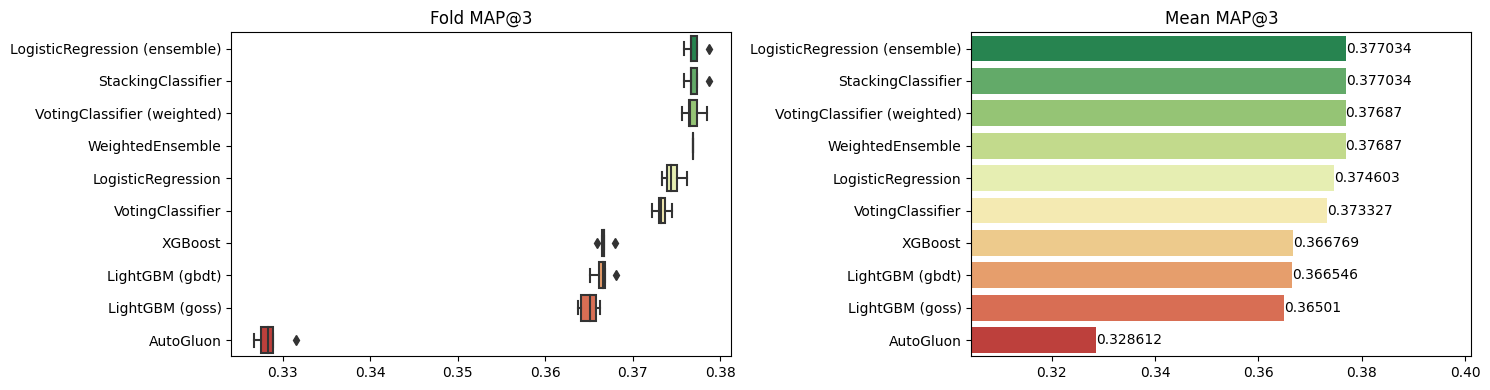

In [22]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", palette="RdYlGn_r")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()